In [505]:
import json
import random
import torch
from pathlib import Path
import torch.nn as nn
import json

torch.cuda.is_available()

True

In [516]:
def load_jsonl(filepath):
    with open(filepath, "r") as f:
        return [json.loads(line) for line in f]

# Load pair data
full_data = load_jsonl("../data_dialogues/pairs.jsonl")
random.seed(42)
random.shuffle(full_data)

# Split train & test
split_ratio = 0.80
split_idx = int(len(full_data) * split_ratio)
train_data = full_data[:split_idx]
test_data = full_data[split_idx:]

# Save split
with open("../data_dialogues/readbacks_train.json", "w") as f:
    json.dump(train_data, f, indent=2)
with open("../data_dialogues/readbacks_test.json", "w") as f:
    json.dump(test_data, f, indent=2)

print(f"Pair data loaded: {len(train_data)} train / {len(test_data)} test")

Pair data loaded: 185 train / 47 test


In [517]:
from transformers import AutoTokenizer
from torch.utils.data import Dataset, DataLoader

MODEL_NAME = "microsoft/MiniLM-L12-H384-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Dataloader
class PairDataset(Dataset):
    def __init__(self, data, tokenizer, max_len=128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        example = self.data[idx]
        encode = self.tokenizer(
            example["instruction"],
            example["readback"],
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )
        item = {
            "input_ids": encode["input_ids"].squeeze(0),
            "attention_mask": encode["attention_mask"].squeeze(0),
            "label": torch.tensor(example["label_id"], dtype=torch.long)
        }
        return item

def make_loader(split, batch_size=32, shuffle=True):
    ds = PairDataset(split, tokenizer)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle)

train_loader = make_loader(train_data, batch_size=32, shuffle=True)
test_loader = make_loader(test_data , batch_size=32, shuffle=False)

# Print out a sample encoding
batch = next(iter(train_loader))
sample_i = 5

ids = batch["input_ids"][sample_i]
mask = batch["attention_mask"][sample_i]
label_id = batch["label"][sample_i].item()

print("Label: ", label_id)
print(tokenizer.decode(ids[mask.bool()].tolist()))
print(ids)
print(mask)
print(label_id)

Label:  0
[CLS] csa five seven three [ ins ] runway three one [ ins ] clear to land wind one nine zero degrees three knots expedite vacating via golf [SEP] [ rbk ] runway three one [ rbk ] clear to land expediting vacating via golf csa [SEP]
tensor([  101, 27804,  2274,  2698,  2093,  1031, 16021,  1033,  9271,  2093,
         2028,  1031, 16021,  1033,  3154,  2000,  2455,  3612,  2028,  3157,
         5717,  5445,  2093,  9439,  4654,  5669,  4221, 12436, 18252,  3081,
         5439,   102,  1031, 21144,  2243,  1033,  9271,  2093,  2028,  1031,
        21144,  2243,  1033,  3154,  2000,  2455,  4654,  5669, 15402, 12436,
        18252,  3081,  5439, 27804,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,

In [518]:
from transformers import AutoModel, AutoConfig

# (matches, partial, incorrect, no_relation)
NUM_RELATIONS = 4

class DialogueRelationModel(nn.Module):
    def __init__(self, model_name, tokenizer, num_labels):
        super().__init__()
        self.config  = AutoConfig.from_pretrained(model_name)
        self.encoder = AutoModel.from_pretrained(model_name, config=self.config)
        # Add special tokens
        self.encoder.resize_token_embeddings(len(tokenizer))
        self.dropout = nn.Dropout(self.config.hidden_dropout_prob)
        self.classifier = nn.Linear(self.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        cls_rep = outputs.last_hidden_state[:, 0, :]
        x = self.dropout(cls_rep)
        logits = self.classifier(x)
        return logits

model = DialogueRelationModel(MODEL_NAME, tokenizer, NUM_RELATIONS).to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")

Total parameters: 33,361,540


In [519]:
from torch.optim import AdamW
from tqdm.auto import tqdm
from sklearn.metrics import classification_report

EPOCHS = 25
LEARNING_RATE = 0.00005
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()

losses = []
# Training
for epoch in range(1, EPOCHS + 1):
    model.train()
    total_loss = 0.0
    loop = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}", leave=False)
    for batch in loop:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        logits = model(input_ids, attention_mask)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        loop.set_postfix(loss=total_loss / (loop.n + 1))

    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch} — Avg Training Loss: {avg_train_loss:.4f}")
    losses.append(avg_train_loss)

    # Eval every epoch
    model.eval()
    preds = []
    true_labels = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids= batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)
            logits = model(input_ids, attention_mask)
            pred_ids = logits.argmax(dim=-1)
            preds.extend(pred_ids.cpu().tolist())
            true_labels.extend(labels.cpu().tolist())

    labels = list(range(NUM_RELATIONS))
    target_names = [
        "matches_instruction",
        "partial_readback",
        "incorrect_readback",
        "no_relation"
    ]
    if epoch == EPOCHS:
        print(classification_report(
            true_labels,
            preds,
            labels = labels,
            target_names = target_names,
            digits = 4,
            zero_division=0
        ))

Epoch 1/25:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1 — Avg Training Loss: 1.1973


Epoch 2/25:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 2 — Avg Training Loss: 1.0672


Epoch 3/25:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 3 — Avg Training Loss: 1.0447


Epoch 4/25:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 4 — Avg Training Loss: 1.0102


Epoch 5/25:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 5 — Avg Training Loss: 0.8610


Epoch 6/25:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 6 — Avg Training Loss: 0.6899


Epoch 7/25:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 7 — Avg Training Loss: 0.6502


Epoch 8/25:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 8 — Avg Training Loss: 0.6483


Epoch 9/25:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 9 — Avg Training Loss: 0.6192


Epoch 10/25:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 10 — Avg Training Loss: 0.4883


Epoch 11/25:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 11 — Avg Training Loss: 0.4408


Epoch 12/25:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 12 — Avg Training Loss: 0.3577


Epoch 13/25:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 13 — Avg Training Loss: 0.2653


Epoch 14/25:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 14 — Avg Training Loss: 0.2841


Epoch 15/25:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 15 — Avg Training Loss: 0.2219


Epoch 16/25:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 16 — Avg Training Loss: 0.2138


Epoch 17/25:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 17 — Avg Training Loss: 0.2550


Epoch 18/25:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 18 — Avg Training Loss: 0.1712


Epoch 19/25:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 19 — Avg Training Loss: 0.1398


Epoch 20/25:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 20 — Avg Training Loss: 0.1601


Epoch 21/25:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 21 — Avg Training Loss: 0.1157


Epoch 22/25:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 22 — Avg Training Loss: 0.0960


Epoch 23/25:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 23 — Avg Training Loss: 0.0809


Epoch 24/25:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 24 — Avg Training Loss: 0.0946


Epoch 25/25:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 25 — Avg Training Loss: 0.1001
                     precision    recall  f1-score   support

matches_instruction     0.5556    0.4167    0.4762        12
   partial_readback     0.1667    1.0000    0.2857         1
 incorrect_readback     0.2727    0.5000    0.3529         6
        no_relation     0.8571    0.6429    0.7347        28

           accuracy                         0.5745        47
          macro avg     0.4630    0.6399    0.4624        47
       weighted avg     0.6908    0.5745    0.6104        47



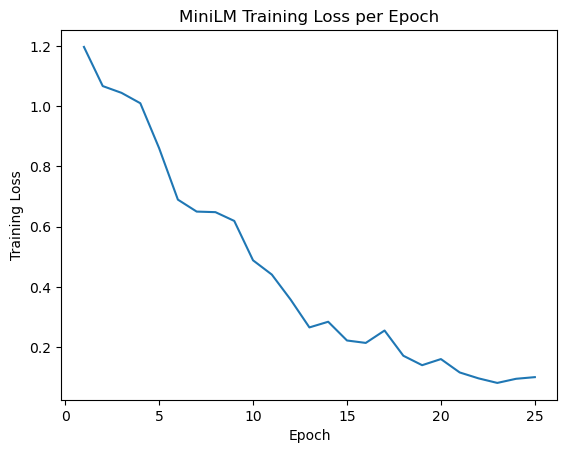

In [520]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(range(1, len(losses) + 1), losses)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("MiniLM Training Loss per Epoch")
plt.show()

In [521]:
id2label = {
    0: "matches_instruction",
    1: "partial_readback",
    2: "incorrect_readback",
    3: "no_relation"
}

# Print out a prediction
def predict_with_confidence(instruction, readback, model, tokenizer, device):
    model.eval()
    inst = f"[INS] {instruction} [INS]"
    rb = f"[RBK] {readback} [RBK]"

    enc = tokenizer(
        inst, rb,
        padding="max_length",
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )
    input_ids = enc["input_ids"].to(device)
    attention_mask = enc["attention_mask"].to(device)
    with torch.no_grad():
        logits = model(input_ids, attention_mask)
        probs  = F.softmax(logits, dim=-1).cpu().squeeze(0)

    top_id    = probs.argmax().item()
    top_label = id2label[top_id]
    top_conf  = probs[top_id].item()

    print(f"Instruction: “{instruction}”")
    print(f"Readback   : “{readback}”\n")
    print(f"Predicted Relation: {top_label}  ({top_conf*100:.1f}% confidence)\n")
    for i in range(len(probs)):
        print(f"{id2label[i]:20s}: {probs[i].item()*100:5.1f}%")

    return top_label, probs

In [522]:
instruction = "delta five one three descend and maintain [ins] flight level two seven zero [ins]"
readback    = "descending [rbk] flight level two eight zero [rbk] delta five one three"

predict_with_confidence(instruction, readback, model, tokenizer, device)

Instruction: “delta five one three descend and maintain [ins] flight level two seven zero [ins]”
Readback   : “descending [rbk] flight level two eight zero [rbk] delta five one three”

Predicted Relation: partial_readback  (88.5% confidence)

matches_instruction :   0.4%
partial_readback    :  88.5%
incorrect_readback  :   8.0%
no_relation         :   3.1%


('partial_readback', tensor([0.0037, 0.8854, 0.0802, 0.0307]))

In [523]:
instruction = "southwest five two two descend and maintain [ins] flight level two seven zero [ins]"
readback    = "descending [rbk] flight level two seven zero [rbk] southwest five two two"

predict_with_confidence(instruction, readback, model, tokenizer, device)

Instruction: “southwest five two two descend and maintain [ins] flight level two seven zero [ins]”
Readback   : “descending [rbk] flight level two seven zero [rbk] southwest five two two”

Predicted Relation: partial_readback  (71.8% confidence)

matches_instruction :   1.3%
partial_readback    :  71.8%
incorrect_readback  :   6.3%
no_relation         :  20.6%


('partial_readback', tensor([0.0130, 0.7178, 0.0628, 0.2064]))

In [524]:
instruction = "southwest five two two descend and maintain [ins] flight level two seven zero [ins]"
readback    = "descending [rbk] flight level two seven zero [rbk] delta three three"

predict_with_confidence(instruction, readback, model, tokenizer, device)

Instruction: “southwest five two two descend and maintain [ins] flight level two seven zero [ins]”
Readback   : “descending [rbk] flight level two seven zero [rbk] delta three three”

Predicted Relation: partial_readback  (82.7% confidence)

matches_instruction :   0.8%
partial_readback    :  82.7%
incorrect_readback  :   6.8%
no_relation         :   9.7%


('partial_readback', tensor([0.0081, 0.8270, 0.0682, 0.0967]))

In [525]:
model.eval()
torch.save(model.state_dict(), "../app/models/dialogue_relation/dialogue_relation_state_dict.pt")
tokenizer.save_pretrained("../app/models/dialogue_relation/tokenizer/")

print("Saved miniLM model!")

Saved miniLM model!
